In [398]:
library(magrittr)
library(dplyr)

In [399]:
train_set = read.csv("../data/kc_house_train_data.csv")
test_set = read.csv("../data/kc_house_test_data.csv")

train_set = train_set[order(train_set$sqft_living),]
test_set = test_set[order(test_set$sqft_living),]

train_set %>% head

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,ellip.h,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15622,3980300371,20140926T000000,142000,0,0,290,20875,1,0,0,⋯,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
681,1723049033,20140620T000000,245000,1,0.75,380,15000,1,0,0,⋯,5,380,0,1963,0,98168,47.481,-122.323,1170,15000
14773,1222029077,20141029T000000,265000,0,0.75,384,213444,1,0,0,⋯,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3916,6896300380,20141002T000000,228000,0,1,390,5900,1,0,0,⋯,4,390,0,1953,0,98118,47.526,-122.261,2170,6000
9261,4322200105,20150331T000000,229050,1,1,420,3298,1,0,0,⋯,4,420,0,1949,0,98136,47.5375,-122.391,1460,4975
370,8658300340,20140523T000000,80000,1,0.75,430,5050,1,0,0,⋯,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500


### Helper Functions

In [400]:
make_feature_matrix = function(data, ...){
    cbind(intercept=rep(1, nrow(data)), as.matrix(select(data, ...)))
}

make_poly_feature_matrix = function(data, order, rowname="x"){
    matr = sapply(0:order, function(i) data^i)
    colnames(matr) = c("const", paste0(rowname, "^", 1:order))
    matr
}

In [401]:
predict_outcome = function(feature_matrix, weights){
    feature_matrix %*% weights
}

In [403]:
rss = function(feature_matrix, output, weights){
    c(t(output - feature_matrix %*% weights) %*% (output - feature_matrix %*% weights))
}

### Ridge Regression Function

In [405]:
ridge_regression = function(feature_matrix, output, initial_weights, 
                            eta, lambda=0, max_iterations=1000){
    weights <- initial_weights
    lambda = c(0, rep(lambda, length(weights)-1))
    counter <- 0
    weight_dev = matrix(ncol=2, nrow=max_iterations)
    for( n in 1:max_iterations ){
        cost_grad = -2*t(feature_matrix) %*% (output - feature_matrix %*% weights)
        cost_grad = cost_grad + 2*lambda*weights
        weights <- weights - eta * cost_grad
    }
    weights
}

### Plot Function

In [406]:
options(repr.plot.width=6, repr.plot.height=5)

plot_test_set = function(weights, dim="sqft_living", size=1000){
    set.seed = 0
    red_test_set = test_set[sort(sample(nrow(test_set), size)), ]
    red_test_matrix = test_matrix[sort(sample(nrow(test_set), size)), ]
    
    test_set = test_set[order(test_set$sqft_living),]
    
    plot(x=red_test_set[,dim], y=red_test_set$price, pch=20, col="gray", 
         ylim=c(1e5,2.5e6), xlim=c(500,6000), xlab="sqft", ylab="price")
    lines(x=red_test_set[,dim], y=predict_outcome(red_test_matrix, weights))
    grid()
}

## Simple Weights Models

In [421]:
test_matrix = make_feature_matrix(test_set, sqft_living)
train_matrix = make_feature_matrix(train_set, sqft_living)
output = train_set$price

In [423]:
step_size = 1e-12
initial_weights = rep(0, 2)

mod_weights = ridge_regression(
    train_matrix, output, initial_weights,eta=step_size, lambda=0)

mod_weights %>% round(., 1)

intercept,-0.2
sqft_living,263


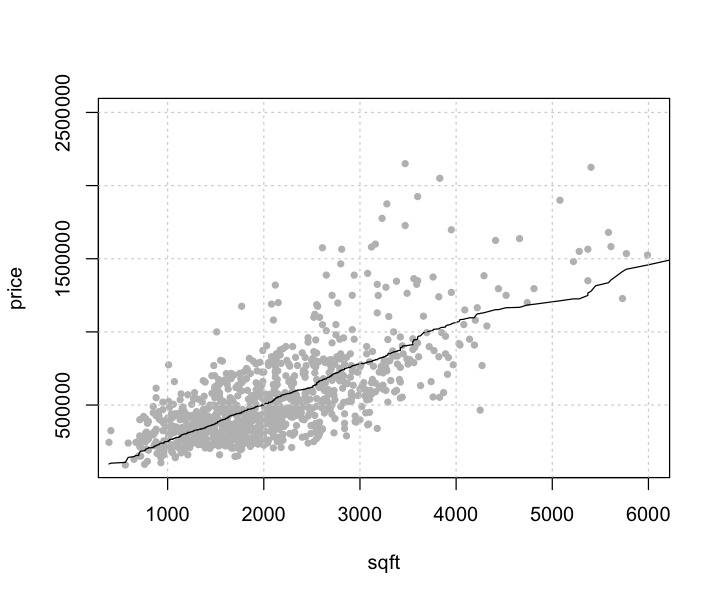

In [409]:
plot_test_set(mod_weights)

In [410]:
rss(test_matrix, test_set$price, mod_weights) %>% format

[1] "2.757236e+14"

In [411]:
mod_r_weights = ridge_regression(
    train_matrix, output, initial_weights,eta=step_size, lambda=1e11)

mod_r_weights %>% round(., 1)

intercept,9.8
sqft_living,124.6


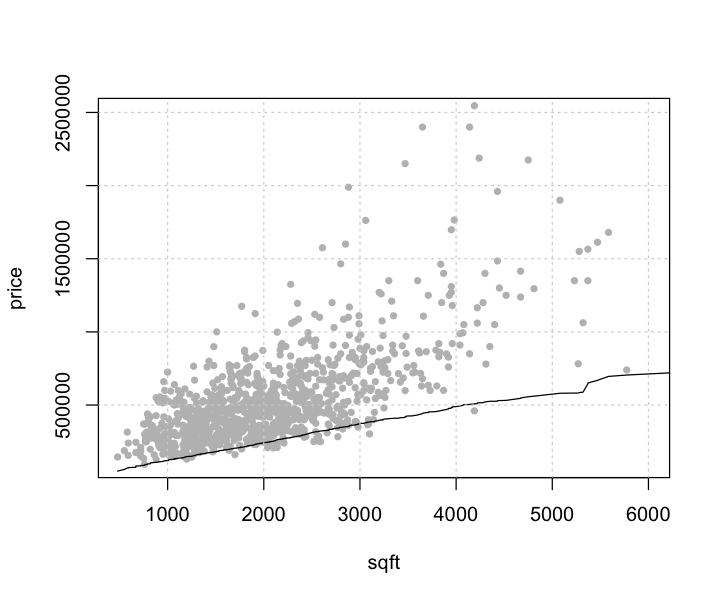

In [412]:
plot_test_set(mod_r_weights)

In [425]:
rss(test_matrix, test_set$price, c(0,0)) %>% format
rss(test_matrix, test_set$price, mod_weights) %>% format
rss(test_matrix, test_set$price, mod_r_weights) %>% format

[1] "1.784273e+15"

[1] "2.757236e+14"

[1] "6.946421e+14"

## Multiple Weights Models

In [427]:
test_matrix = make_feature_matrix(test_set, sqft_living, sqft_living15)
train_matrix = make_feature_matrix(train_set, sqft_living, sqft_living15)

In [415]:
step_size = 1e-12
initial_weights = rep(0, 3)

mod_weights2 = ridge_regression(
    train_matrix, output, initial_weights,eta=step_size, lambda=0)

mod_weights2 %>% round(., 1)

intercept,-0.4
sqft_living,243.1
sqft_living15,22.4


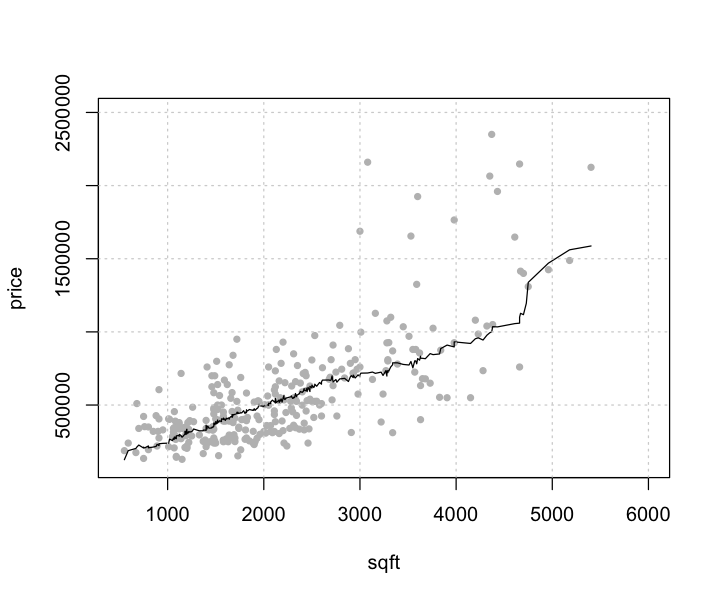

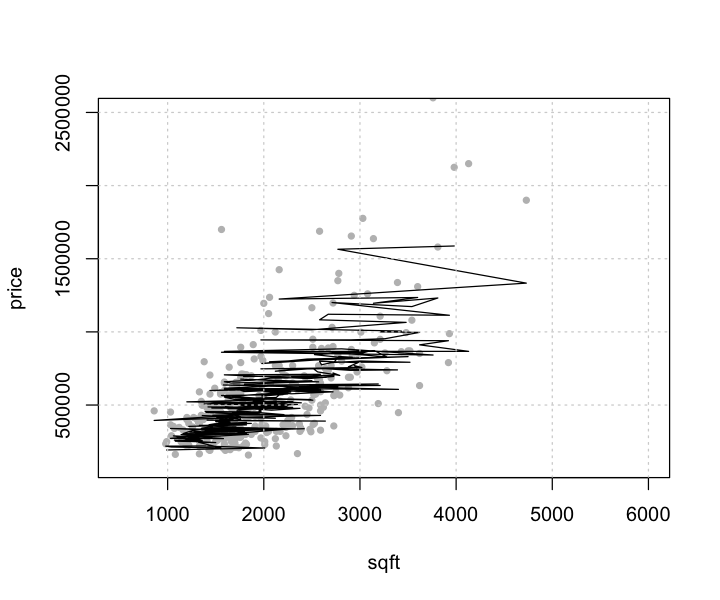

In [416]:
plot_test_set(mod_weights2, size=300)
plot_test_set(mod_weights2, dim="sqft_living15", size=300)

In [417]:
rss(test_matrix, test_set$price, mod_weights2) %>% format

[1] "2.740676e+14"

In [418]:
mod_r_weights2 = ridge_regression(
    train_matrix, output, initial_weights,eta=step_size, lambda=1e11)

mod_r_weights2 %>% round(., 1)

intercept,6.7
sqft_living,91.5
sqft_living15,78.4


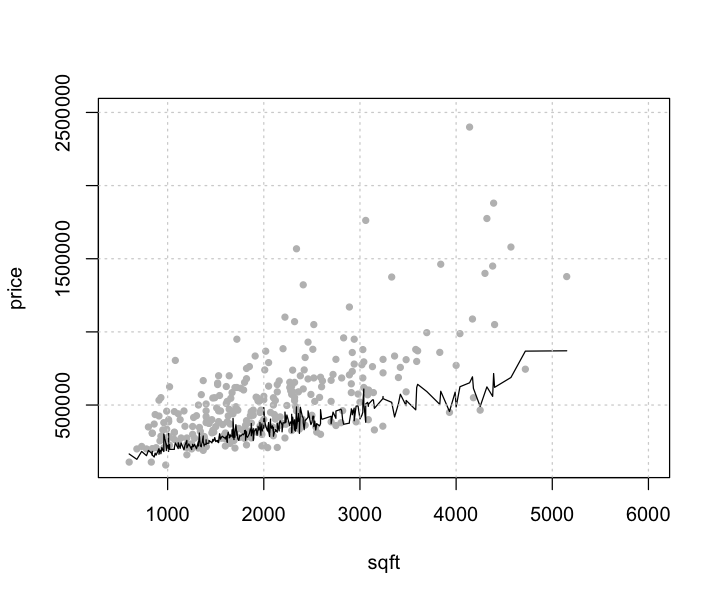

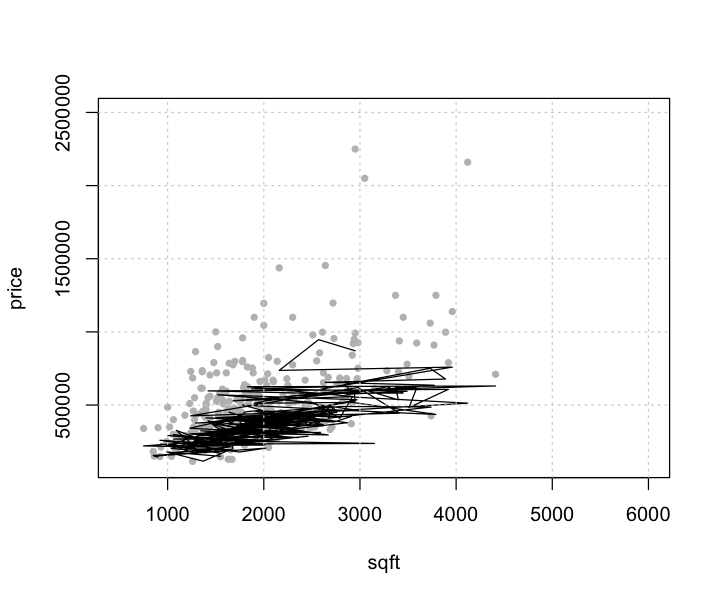

In [419]:
plot_test_set(mod_r_weights2, size=300)
plot_test_set(mod_r_weights2, dim="sqft_living15", size=300)

In [428]:
rss(test_matrix, test_set$price, c(0,0,0)) %>% format
rss(test_matrix, test_set$price, mod_weights2) %>% format
rss(test_matrix, test_set$price, mod_r_weights2) %>% format

[1] "1.784273e+15"

[1] "2.740676e+14"

[1] "5.004048e+14"

In [433]:
test_set$price[1]
predict_outcome(test_matrix[1,], mod_weights2)
predict_outcome(test_matrix[1,], mod_r_weights2)

[1] 276000

119965.5


138962.8
